<a href="https://colab.research.google.com/github/fsternini/prod-opt/blob/development/prod_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

In [ ]:
# First, verification of Python version is completed
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [ ]:

!git clone 'https://github.com/fsternini/prod-opt.git'
%cd 'prod-opt'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'prod-opt'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (20/20), 130.79 KiB | 3.35 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/prod-opt
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


In [ ]:
# Install all requirements for the code
!pip install -r requirements.txt -q
# Google Drive is mounted, to reach and save all relevant data
from google.colab import drive
import os
import colab_env
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


drive.mount('/content/drive')
dataset_path = os.environ['PROD_DATASET']

  Preparing metadata (setup.py) ... done
Mounted at /content/gdrive
Mounted at /content/drive


#Data loading

In [ ]:
df = pd.read_csv(dataset_path+"/training_set_data_science.tsv", delimiter="\t")

The number of samples is obtained for each class

In [ ]:
df.groupby("class").count()

,id,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74
class,,,,,,,,,,,,,,,,,,,,,
0.0,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111
0.5,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
1.0,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284,...,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284


The dataset is highly imbalanced; therefore, some solutions to manage problems with underrepresented classes should be considered.

In [ ]:
df.isnull().sum().unique()

array([0])

No missing values are found in the dataset. No further actions for the missing value problem are required

In [ ]:
for i in df.columns:
  print(df[i].dtypes)

float64
int64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
int64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
int64
int64
float64
int64
int64
float64
int64
int64
int64
float64
int64
int64
int64
int64
float64
int64
int64
int64
float64
int64
int64
float64
float64
int64
float64
float64
float64
float64


All the variables to be considered are numerical

In [ ]:
df['class']=df["class"].replace({0:"fail",0.5:"low",1.0:"success"})

In [ ]:
df.groupby("class").count()

,id,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74
class,,,,,,,,,,,,,,,,,,,,,
fail,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111
low,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
success,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284,...,1284,1284,1284,1284,1284,1284,1284,1284,1284,1284


In [ ]:
df.head()
X=np.array(df.drop(["class","id"],axis=1))

In [ ]:
y = np.array(df["class"])

#1st iteration


First, a set of classifiers are trained using all the classes in the dataset.

The k-fold technique is used to identify the most promising and robust technique before using test production data (the test dataset provided)

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


##Linear SVM

Considering the high number of variables, the first choice is to use SVM, as it can linearly separate high-dimensional data.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


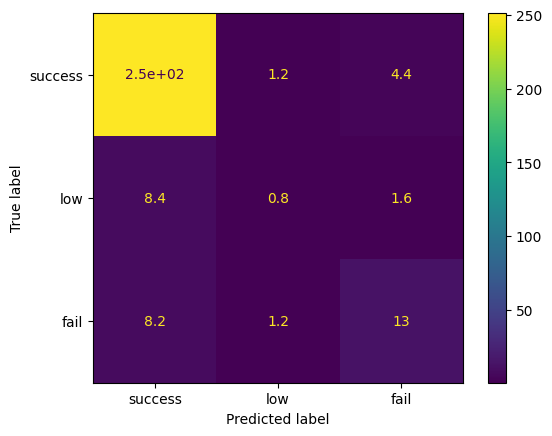

{'SVM': {'Fold_0': {'success': {'Precision': 0.9296296296296296, 'Recall': 0.9766536964980544, 'FScore': 0.9525616698292219, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.6875, 'Recall': 0.5, 'FScore': 0.5789473684210527, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9609375, 'Recall': 0.9571984435797666, 'FScore': 0.9590643274853801, 'Support': 257}, 'low': {'Precision': 0.3333333333333333, 'Recall': 0.2727272727272727, 'FScore': 0.3, 'Support': 11}, 'fail': {'Precision': 0.64, 'Recall': 0.7272727272727273, 'FScore': 0.6808510638297872, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.933579335793358, 'Recall': 0.9844357976653697, 'FScore': 0.9583333333333334, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.631578947368421, 'Recall': 0.5454545454545454, 'FScore': 0.5853658536585366, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.923

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = ["success","low","fail"]
results={"SVM":{}}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y[train_index]
  x_test = X[test_index]
  y_test = y[test_index]
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["SVM"][fold]={}
  for j in range(len(labels)):
    results["SVM"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)

Considering the need to reduce false positives to reduce the impact on the production, the Recall in the fail class shall be considered a priority. Therefore, this metric is further analysed to compare the algorithms.

In [ ]:
recalls={"SVM":[]}
for key in results["SVM"]:
  recalls["SVM"].append(results["SVM"][key]["fail"]["Recall"])

##Linear SVM and SMOTE

The SMOTE technique is tested to improve the performance of the classification of underrepresented categories.

In [ ]:
resampler = SMOTE(sampling_strategy="not majority", random_state=42)

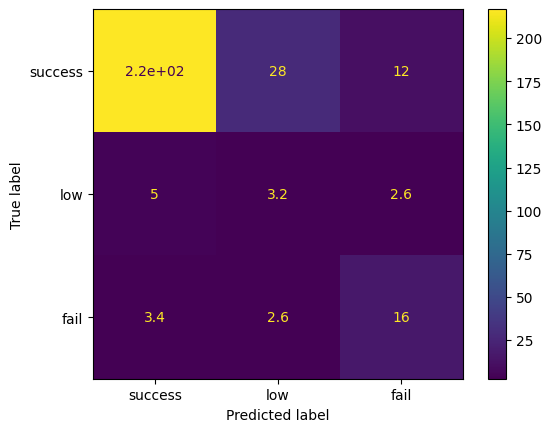

{'SVM': {'Fold_0': {'success': {'Precision': 0.9296296296296296, 'Recall': 0.9766536964980544, 'FScore': 0.9525616698292219, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.6875, 'Recall': 0.5, 'FScore': 0.5789473684210527, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9609375, 'Recall': 0.9571984435797666, 'FScore': 0.9590643274853801, 'Support': 257}, 'low': {'Precision': 0.3333333333333333, 'Recall': 0.2727272727272727, 'FScore': 0.3, 'Support': 11}, 'fail': {'Precision': 0.64, 'Recall': 0.7272727272727273, 'FScore': 0.6808510638297872, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.933579335793358, 'Recall': 0.9844357976653697, 'FScore': 0.9583333333333334, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.631578947368421, 'Recall': 0.5454545454545454, 'FScore': 0.5853658536585366, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.923

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
results["SVM_RES"]={}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y[train_index]
  x_test = X[test_index]
  y_test = y[test_index]
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  clf.fit(x_res, y_res)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["SVM_RES"][fold]={}
  for j in range(len(labels)):
    results["SVM_RES"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)
recalls["SVM_RES"]=[]
for key in results["SVM_RES"]:
  recalls["SVM_RES"].append(results["SVM_RES"][key]["fail"]["Recall"])

##XGB

The third trial is related to adopting Extreme Gradient Boosting algorithms, which are highly efficient in classification.

[0]	validation_0-mlogloss:0.77556
[1]	validation_0-mlogloss:0.59619
[2]	validation_0-mlogloss:0.48230
[3]	validation_0-mlogloss:0.41241
[4]	validation_0-mlogloss:0.36631
[5]	validation_0-mlogloss:0.33391
[6]	validation_0-mlogloss:0.31433
[7]	validation_0-mlogloss:0.30306
[8]	validation_0-mlogloss:0.29794
[9]	validation_0-mlogloss:0.29335
[10]	validation_0-mlogloss:0.29257
[11]	validation_0-mlogloss:0.29345
[12]	validation_0-mlogloss:0.29395
[0]	validation_0-mlogloss:0.77435
[1]	validation_0-mlogloss:0.59808
[2]	validation_0-mlogloss:0.48636
[3]	validation_0-mlogloss:0.41127
[4]	validation_0-mlogloss:0.35544
[5]	validation_0-mlogloss:0.32075
[6]	validation_0-mlogloss:0.29739
[7]	validation_0-mlogloss:0.28142
[8]	validation_0-mlogloss:0.27031
[9]	validation_0-mlogloss:0.26631
[10]	validation_0-mlogloss:0.26489
[11]	validation_0-mlogloss:0.26469
[12]	validation_0-mlogloss:0.26514
[0]	validation_0-mlogloss:0.77171
[1]	validation_0-mlogloss:0.58660
[2]	validation_0-mlogloss:0.47221
[3]	vali

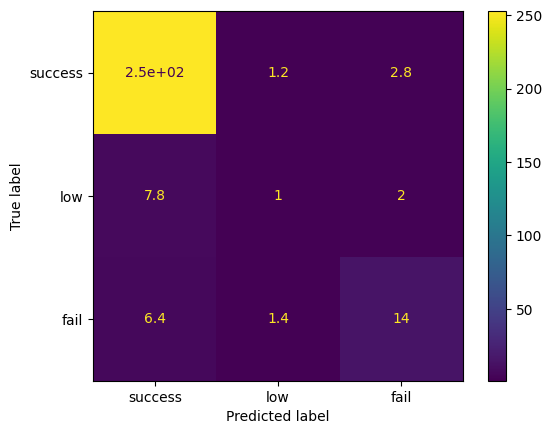

{'SVM': {'Fold_0': {'success': {'Precision': 0.9296296296296296, 'Recall': 0.9766536964980544, 'FScore': 0.9525616698292219, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.6875, 'Recall': 0.5, 'FScore': 0.5789473684210527, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9609375, 'Recall': 0.9571984435797666, 'FScore': 0.9590643274853801, 'Support': 257}, 'low': {'Precision': 0.3333333333333333, 'Recall': 0.2727272727272727, 'FScore': 0.3, 'Support': 11}, 'fail': {'Precision': 0.64, 'Recall': 0.7272727272727273, 'FScore': 0.6808510638297872, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.933579335793358, 'Recall': 0.9844357976653697, 'FScore': 0.9583333333333334, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.631578947368421, 'Recall': 0.5454545454545454, 'FScore': 0.5853658536585366, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.923

In [ ]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y_enc = label_encoder.transform(y)

model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
results["XGB"]={}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y_enc)):
  x_train = X[train_index]
  y_train = y_enc[train_index]
  x_test = X[test_index]
  y_test = y_enc[test_index]
  x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
  clf_xgb.fit(x_train, y_train, xgbclassifier__eval_set=[(x_eval, y_eval)])
  y_pred = clf_xgb.predict(x_test)
  y_pred = label_encoder.inverse_transform(y_pred)
  y_test = label_encoder.inverse_transform(y_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["XGB"][fold]={}
  for j in range(len(labels)):
    results["XGB"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)
recalls["XGB"]=[]
for key in results["XGB"]:
  recalls["XGB"].append(results["XGB"][key]["fail"]["Recall"])

##XGB and SMOTE

First, it is tried without resampling, then with resampling strategies.

[0]	validation_0-mlogloss:0.78497
[1]	validation_0-mlogloss:0.60479
[2]	validation_0-mlogloss:0.49284
[3]	validation_0-mlogloss:0.41934
[4]	validation_0-mlogloss:0.37168
[5]	validation_0-mlogloss:0.33936
[6]	validation_0-mlogloss:0.31674
[7]	validation_0-mlogloss:0.29874
[8]	validation_0-mlogloss:0.28643
[9]	validation_0-mlogloss:0.28240
[10]	validation_0-mlogloss:0.27902
[11]	validation_0-mlogloss:0.27803
[12]	validation_0-mlogloss:0.27726
[13]	validation_0-mlogloss:0.27753
[0]	validation_0-mlogloss:0.79908
[1]	validation_0-mlogloss:0.62061
[2]	validation_0-mlogloss:0.50246
[3]	validation_0-mlogloss:0.41939
[4]	validation_0-mlogloss:0.35935
[5]	validation_0-mlogloss:0.31900
[6]	validation_0-mlogloss:0.29269
[7]	validation_0-mlogloss:0.27490
[8]	validation_0-mlogloss:0.25994
[9]	validation_0-mlogloss:0.25274
[10]	validation_0-mlogloss:0.24593
[11]	validation_0-mlogloss:0.24428
[12]	validation_0-mlogloss:0.24303
[13]	validation_0-mlogloss:0.24204
[14]	validation_0-mlogloss:0.24396
[15]	

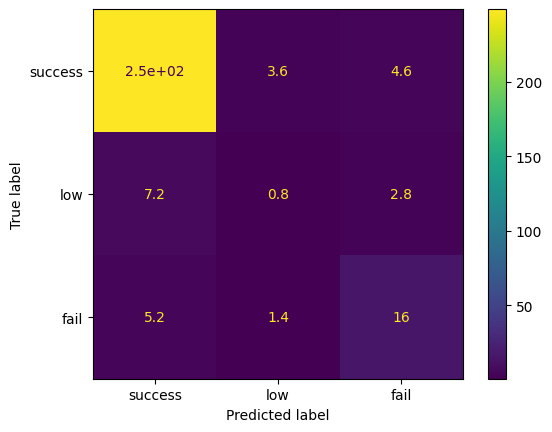

{'SVM': {'Fold_0': {'success': {'Precision': 0.9296296296296296, 'Recall': 0.9766536964980544, 'FScore': 0.9525616698292219, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.6875, 'Recall': 0.5, 'FScore': 0.5789473684210527, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9609375, 'Recall': 0.9571984435797666, 'FScore': 0.9590643274853801, 'Support': 257}, 'low': {'Precision': 0.3333333333333333, 'Recall': 0.2727272727272727, 'FScore': 0.3, 'Support': 11}, 'fail': {'Precision': 0.64, 'Recall': 0.7272727272727273, 'FScore': 0.6808510638297872, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.933579335793358, 'Recall': 0.9844357976653697, 'FScore': 0.9583333333333334, 'Support': 257}, 'low': {'Precision': 0.0, 'Recall': 0.0, 'FScore': 0.0, 'Support': 11}, 'fail': {'Precision': 0.631578947368421, 'Recall': 0.5454545454545454, 'FScore': 0.5853658536585366, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.923

In [ ]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y_enc = label_encoder.transform(y)

model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)

results["XGB_res"]={}
cm=np.zeros((5,len(labels),len(labels)))
for i, (train_index, test_index) in enumerate(skf.split(X, y_enc)):
  x_train = X[train_index]
  y_train = y_enc[train_index]
  x_test = X[test_index]
  y_test = y_enc[test_index]
  x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  clf_xgb.fit(x_res, y_res, xgbclassifier__eval_set=[(x_eval, y_eval)])
  y_pred = clf_xgb.predict(x_test)
  y_pred = label_encoder.inverse_transform(y_pred)
  y_test = label_encoder.inverse_transform(y_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results["XGB_res"][fold]={}
  for j in range(len(labels)):
    results["XGB_res"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results)
recalls["XGB_res"]=[]
for key in results["XGB_res"]:
  recalls["XGB_res"].append(results["XGB_res"][key]["fail"]["Recall"])

In [ ]:
rec =[]
titles = []
for key, value in recalls.items():
  titles.append(key)
  rec.append(value)

Text(0.5, 1.0, 'Recall of fail class')

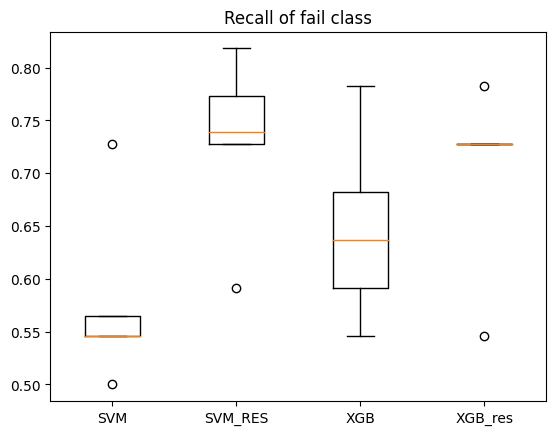

In [ ]:
plt.boxplot(rec,labels=titles)
plt.title("Recall of fail class")

As can be seen, the results are far from excellent, but the plot highlights the higher performances of SVM with SMOTE.

#2nd iteration (merging of low and success categories)

The same approach is tested by merging the two categories, success and low, to improve the capability of the classifiers to discriminate the fail samples.

In [ ]:
y = np.array(df["class"])

In [ ]:
ym = np.array(y, copy=True)
ym[ym=="low"]="success"

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


##Linear SVM

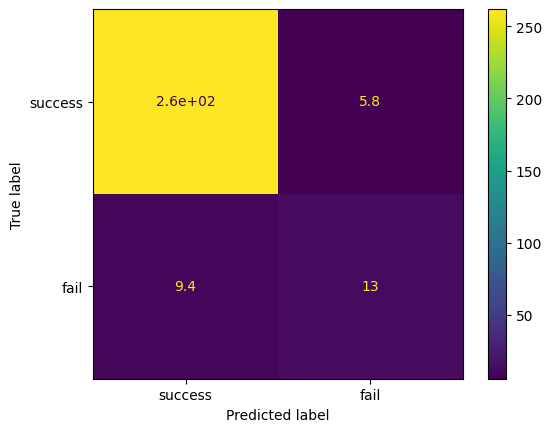

{'SVM': {'Fold_0': {'success': {'Precision': 0.96, 'Recall': 0.9850746268656716, 'FScore': 0.9723756906077348, 'Support': 268}, 'fail': {'Precision': 0.7333333333333333, 'Recall': 0.5, 'FScore': 0.5945945945945945, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9735849056603774, 'Recall': 0.9626865671641791, 'FScore': 0.9681050656660413, 'Support': 268}, 'fail': {'Precision': 0.6, 'Recall': 0.6818181818181818, 'FScore': 0.6382978723404256, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.9633699633699634, 'Recall': 0.9813432835820896, 'FScore': 0.9722735674676525, 'Support': 268}, 'fail': {'Precision': 0.7058823529411765, 'Recall': 0.5454545454545454, 'FScore': 0.6153846153846153, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.9636363636363636, 'Recall': 0.9888059701492538, 'FScore': 0.9760589318600369, 'Support': 268}, 'fail': {'Precision': 0.8, 'Recall': 0.5454545454545454, 'FScore': 0.6486486486486486, 'Support': 22}}, 'Fold_4': {'success': {'Precision': 0.9664

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = ["success","fail"]
results_m={"SVM":{}}
cm=np.zeros((5,len(labels),len(labels)))

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = ym[train_index]
  x_test = X[test_index]
  y_test = ym[test_index]
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["SVM"][fold]={}
  for j in range(len(labels)):
    results_m["SVM"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)


In [ ]:
recalls_m={"SVM":[]}
for key in results_m["SVM"]:
  recalls_m["SVM"].append(results_m["SVM"][key]["fail"]["Recall"])

In [ ]:
recalls_m

{'SVM': [0.5,
  0.6818181818181818,
  0.5454545454545454,
  0.5454545454545454,
  0.6086956521739131]}

##Linear SVM and SMOTE

In [ ]:
resampler = SMOTE(sampling_strategy="not majority", random_state=42)

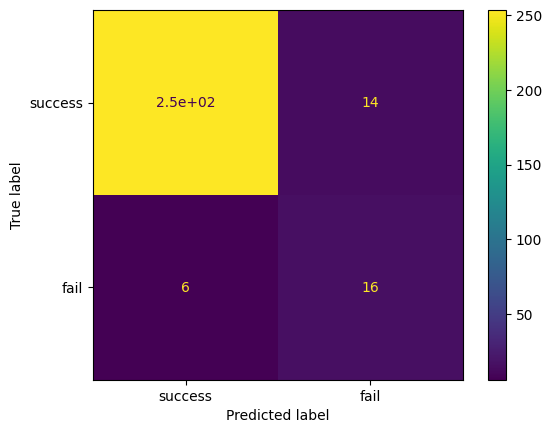

{'SVM': {'Fold_0': {'success': {'Precision': 0.96, 'Recall': 0.9850746268656716, 'FScore': 0.9723756906077348, 'Support': 268}, 'fail': {'Precision': 0.7333333333333333, 'Recall': 0.5, 'FScore': 0.5945945945945945, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9735849056603774, 'Recall': 0.9626865671641791, 'FScore': 0.9681050656660413, 'Support': 268}, 'fail': {'Precision': 0.6, 'Recall': 0.6818181818181818, 'FScore': 0.6382978723404256, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.9633699633699634, 'Recall': 0.9813432835820896, 'FScore': 0.9722735674676525, 'Support': 268}, 'fail': {'Precision': 0.7058823529411765, 'Recall': 0.5454545454545454, 'FScore': 0.6153846153846153, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.9636363636363636, 'Recall': 0.9888059701492538, 'FScore': 0.9760589318600369, 'Support': 268}, 'fail': {'Precision': 0.8, 'Recall': 0.5454545454545454, 'FScore': 0.6486486486486486, 'Support': 22}}, 'Fold_4': {'success': {'Precision': 0.9664

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
cm=np.zeros((5,len(labels),len(labels)))
results_m["SVM_RES"]={}
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y[train_index]
  x_test = X[test_index]
  y_test = ym[test_index]
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  y_res[y_res=="low"]="success"
  clf.fit(x_res, y_res)
  y_pred = clf.predict(x_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["SVM_RES"][fold]={}
  for j in range(len(labels)):
    results_m["SVM_RES"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)
recalls_m["SVM_RES"]=[]
for key in results_m["SVM_RES"]:
  recalls_m["SVM_RES"].append(results_m["SVM_RES"][key]["fail"]["Recall"])

##XGB

In this section, further work shall be done to fix the evaluation dataset sorting to be stratified also for the underrepresented category "low", but I had no time to complete it.

[0]	validation_0-logloss:0.21855
[1]	validation_0-logloss:0.18602
[2]	validation_0-logloss:0.16417
[3]	validation_0-logloss:0.14976
[4]	validation_0-logloss:0.14080
[5]	validation_0-logloss:0.13302
[6]	validation_0-logloss:0.12991
[7]	validation_0-logloss:0.12704
[8]	validation_0-logloss:0.12334
[9]	validation_0-logloss:0.12153
[10]	validation_0-logloss:0.12236
[11]	validation_0-logloss:0.12047
[12]	validation_0-logloss:0.11987
[13]	validation_0-logloss:0.11888
[14]	validation_0-logloss:0.11833
[15]	validation_0-logloss:0.11754
[16]	validation_0-logloss:0.11860
[17]	validation_0-logloss:0.11807
[0]	validation_0-logloss:0.21215
[1]	validation_0-logloss:0.17452
[2]	validation_0-logloss:0.15264
[3]	validation_0-logloss:0.14004
[4]	validation_0-logloss:0.12915
[5]	validation_0-logloss:0.12023
[6]	validation_0-logloss:0.11259
[7]	validation_0-logloss:0.11240
[8]	validation_0-logloss:0.10929
[9]	validation_0-logloss:0.11006
[0]	validation_0-logloss:0.23548
[1]	validation_0-logloss:0.19475
[2

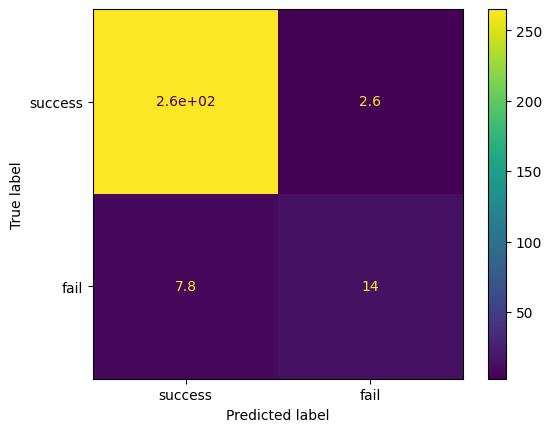

{'SVM': {'Fold_0': {'success': {'Precision': 0.96, 'Recall': 0.9850746268656716, 'FScore': 0.9723756906077348, 'Support': 268}, 'fail': {'Precision': 0.7333333333333333, 'Recall': 0.5, 'FScore': 0.5945945945945945, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9735849056603774, 'Recall': 0.9626865671641791, 'FScore': 0.9681050656660413, 'Support': 268}, 'fail': {'Precision': 0.6, 'Recall': 0.6818181818181818, 'FScore': 0.6382978723404256, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.9633699633699634, 'Recall': 0.9813432835820896, 'FScore': 0.9722735674676525, 'Support': 268}, 'fail': {'Precision': 0.7058823529411765, 'Recall': 0.5454545454545454, 'FScore': 0.6153846153846153, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.9636363636363636, 'Recall': 0.9888059701492538, 'FScore': 0.9760589318600369, 'Support': 268}, 'fail': {'Precision': 0.8, 'Recall': 0.5454545454545454, 'FScore': 0.6486486486486486, 'Support': 22}}, 'Fold_4': {'success': {'Precision': 0.9664

In [ ]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(ym)
y_enc = label_encoder.transform(ym)

model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
cm=np.zeros((5,len(labels),len(labels)))
results_m["XGB"]={}
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y_enc[train_index]
  x_test = X[test_index]
  y_test = y_enc[test_index]
  x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
  clf_xgb.fit(x_train, y_train, xgbclassifier__eval_set=[(x_eval, y_eval)])
  y_pred = clf_xgb.predict(x_test)
  y_pred = label_encoder.inverse_transform(y_pred)
  y_test = label_encoder.inverse_transform(y_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["XGB"][fold]={}
  for j in range(len(labels)):
    results_m["XGB"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)
recalls_m["XGB"]=[]
for key in results_m["XGB"]:
  recalls_m["XGB"].append(results_m["XGB"][key]["fail"]["Recall"])

##XGB and SMOTE

[0]	validation_0-logloss:0.33904
[1]	validation_0-logloss:0.26334
[2]	validation_0-logloss:0.21492
[3]	validation_0-logloss:0.17890
[4]	validation_0-logloss:0.15716
[5]	validation_0-logloss:0.14009
[6]	validation_0-logloss:0.13015
[7]	validation_0-logloss:0.12377
[8]	validation_0-logloss:0.11930
[9]	validation_0-logloss:0.11582
[10]	validation_0-logloss:0.11182
[11]	validation_0-logloss:0.11051
[12]	validation_0-logloss:0.10856
[13]	validation_0-logloss:0.10862
[0]	validation_0-logloss:0.34905
[1]	validation_0-logloss:0.27757
[2]	validation_0-logloss:0.23095
[3]	validation_0-logloss:0.19716
[4]	validation_0-logloss:0.17843
[5]	validation_0-logloss:0.16669
[6]	validation_0-logloss:0.15722
[7]	validation_0-logloss:0.14988
[8]	validation_0-logloss:0.14539
[9]	validation_0-logloss:0.13952
[10]	validation_0-logloss:0.13766
[11]	validation_0-logloss:0.13215
[12]	validation_0-logloss:0.13358
[0]	validation_0-logloss:0.33725
[1]	validation_0-logloss:0.26316
[2]	validation_0-logloss:0.21603
[3]

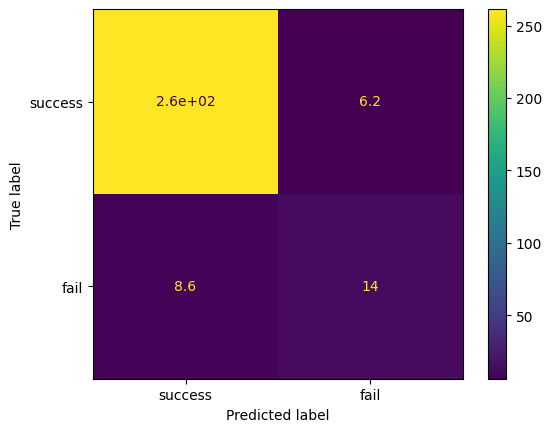

{'SVM': {'Fold_0': {'success': {'Precision': 0.96, 'Recall': 0.9850746268656716, 'FScore': 0.9723756906077348, 'Support': 268}, 'fail': {'Precision': 0.7333333333333333, 'Recall': 0.5, 'FScore': 0.5945945945945945, 'Support': 22}}, 'Fold_1': {'success': {'Precision': 0.9735849056603774, 'Recall': 0.9626865671641791, 'FScore': 0.9681050656660413, 'Support': 268}, 'fail': {'Precision': 0.6, 'Recall': 0.6818181818181818, 'FScore': 0.6382978723404256, 'Support': 22}}, 'Fold_2': {'success': {'Precision': 0.9633699633699634, 'Recall': 0.9813432835820896, 'FScore': 0.9722735674676525, 'Support': 268}, 'fail': {'Precision': 0.7058823529411765, 'Recall': 0.5454545454545454, 'FScore': 0.6153846153846153, 'Support': 22}}, 'Fold_3': {'success': {'Precision': 0.9636363636363636, 'Recall': 0.9888059701492538, 'FScore': 0.9760589318600369, 'Support': 268}, 'fail': {'Precision': 0.8, 'Recall': 0.5454545454545454, 'FScore': 0.6486486486486486, 'Support': 22}}, 'Fold_4': {'success': {'Precision': 0.9664

In [ ]:
label_encoder_three = LabelEncoder()
label_encoder_three = label_encoder_three.fit(y)
y_enc_three = label_encoder_three.transform(y)
label_encoder_two = LabelEncoder()
label_encoder_two = label_encoder_two.fit(ym)
y_enc_two = label_encoder_two.transform(ym)

model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
cm=np.zeros((5,len(labels),len(labels)))
results_m["XGB_res"]={}
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  x_train = X[train_index]
  y_train = y_enc_three[train_index]
  x_test = X[test_index]
  y_test = y_enc_two[test_index]
  x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
  y_eval = label_encoder_three.inverse_transform(y_eval)
  y_eval[y_eval=="low"]="success"
  y_eval = label_encoder_two.transform(y_eval)
  x_res, y_res = resampler.fit_resample(x_train,y_train)
  y_res = label_encoder_three.inverse_transform(y_res)
  y_res[y_res=="low"]="success"
  y_res=label_encoder_two.transform(y_res)
  clf_xgb.fit(x_res, y_res, xgbclassifier__eval_set=[(x_eval, y_eval)])
  y_pred = clf_xgb.predict(x_test)
  y_pred = label_encoder.inverse_transform(y_pred)
  y_test = label_encoder.inverse_transform(y_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
  fold = "Fold_"+str(i)
  results_m["XGB_res"][fold]={}
  for j in range(len(labels)):
    results_m["XGB_res"][fold][labels[j]] = {"Precision":precision[j],
                          "Recall":recall[j],
                          "FScore":fscore[j],
                          "Support":support[j]
                                }
  cm[i]=confusion_matrix(y_test, y_pred, labels=labels)

cm=np.average(cm,axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(results_m)
recalls_m["XGB_res"]=[]
for key in results_m["XGB_res"]:
  recalls_m["XGB_res"].append(results_m["XGB"][key]["fail"]["Recall"])

In [ ]:
rec =[]
titles = []
for key, value in recalls.items():
  titles.append(key)
  titles.append(key+"merged")
  rec.append(value)
  rec.append(recalls_m[key])


Text(0.5, 1.0, 'Recall for Fail class')

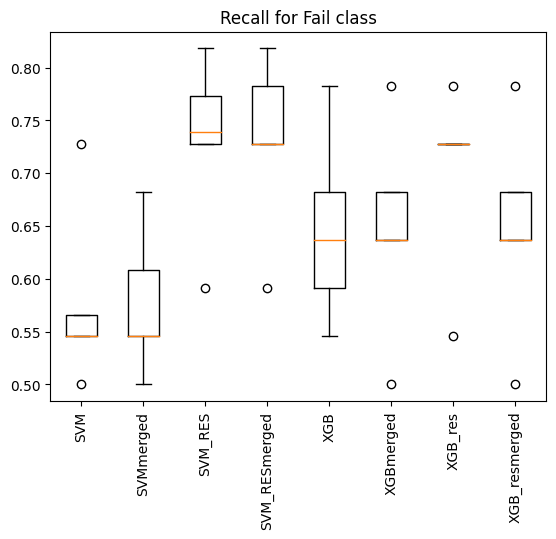

In [ ]:
plt.boxplot(rec,labels=titles)
plt.xticks(rotation=90)
plt.title("Recall for Fail class")

#Discussion of results and next steps

Considering the results, the Linear SVM with SMOTE was one of the promising algorithms; it was efficient, quick to train, and can be lightweight to deploy. The main limitation of this work is the absence of feature engineering and the limited work on the starting dataset. For example, feature selection, feature generation, or further work on oversampling techniques to mitigate the imbalance could result in significant improvements. Furthermore, other potential improvements can be the adoption of more complex algorithms (like Neural Networks) and more complex optimisation algorithms capable of being tuned to manage the imbalance of the classes. With the current work, the most promising approach is training a Linear SVM model with the whole dataset and its production trial.